In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# إعدادات التصوير
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
# تحميل البيانات
df = pd.read_csv('Delivery_Logistics_TimeFixed.csv')

# عرض معلومات البيانات
print("="*50)
print("🔍 معلومات البيانات:")
print("="*50)
print(f"عدد الصفوف: {df.shape[0]}")
print(f"عدد الأعمدة: {df.shape[1]}")
print("\nالأعمدة:", df.columns.tolist())

# عرض أول 5 صفوف
print("\n" + "="*50)
print("📋 أول 5 صفوف:")
print("="*50)
print(df.head())

# معلومات إحصائية
print("\n" + "="*50)
print("📊 معلومات إحصائية:")
print("="*50)
print(df.describe())

# التحقق من القيم المفقودة
print("\n" + "="*50)
print("🔎 القيم المفقودة:")
print("="*50)
print(df.isnull().sum())

🔍 معلومات البيانات:
عدد الصفوف: 25000
عدد الأعمدة: 16

الأعمدة: ['delivery_id', 'delivery_partner', 'package_type', 'vehicle_type', 'delivery_mode', 'region', 'weather_condition', 'distance_km', 'package_weight_kg', 'delayed', 'delivery_status', 'delivery_rating', 'delivery_cost', 'actual_delivery_hours', 'expected_delivery_hours', 'delivery_delay_hours']

📋 أول 5 صفوف:
   delivery_id delivery_partner      package_type vehicle_type delivery_mode  \
0            1        delhivery  automobile parts         bike      same day   
1            2       xpressbees         cosmetics       ev van       express   
2            3        shadowfax         groceries        truck       two day   
3            4              dhl       electronics       ev van      same day   
4            5              dhl          clothing          van       two day   

    region weather_condition  distance_km  package_weight_kg delayed  \
0     west             clear        297.0              46.96      no   
1 


🧮 إعداد البيانات للـ REGRESSION


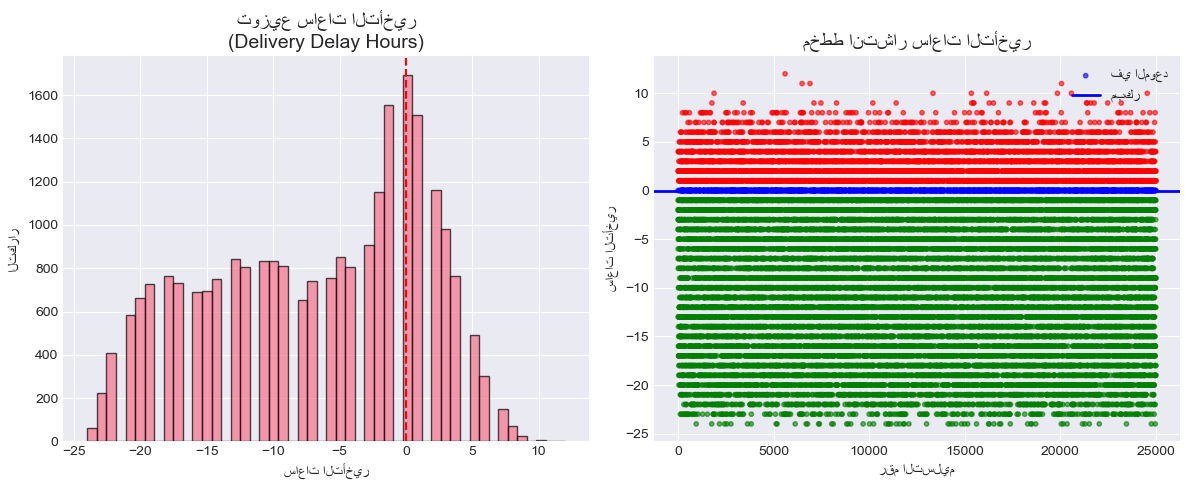


📈 إحصائيات ساعات التأخير:
• المتوسط: -6.86 ساعة
• الوسيط: -6.00 ساعة
• الانحراف المعياري: 8.07 ساعة
• الحد الأدنى: -24.00 ساعة
• الحد الأقصى: 12.00 ساعة
• نسبة التسليم المبكر (تأخير < 0): 71.4%
• نسبة التسليم في الموعد (تأخير = 0): 6.8%
• نسبة التسليم المتأخر (تأخير > 0): 21.9%


In [3]:
print("\n" + "="*50)
print("🧮 إعداد البيانات للـ REGRESSION")
print("="*50)

# نسخة للـ regression
df_reg = df.copy()

# الهدف: delivery_delay_hours
y_reg = df_reg['delivery_delay_hours']

# الميزات: كل شيء ما عدا المتغيرات المستهدفة
X_reg = df_reg.drop(['delivery_delay_hours', 'delayed', 'delivery_status', 'delivery_id', 'actual_delivery_hours', 'expected_delivery_hours'], axis=1)

# عرض توزيع الهدف
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(y_reg, bins=50, edgecolor='black', alpha=0.7)
plt.title('توزيع ساعات التأخير\n(Delivery Delay Hours)', fontsize=14)
plt.xlabel('ساعات التأخير')
plt.ylabel('التكرار')
plt.axvline(x=0, color='red', linestyle='--', label='في الموعد')

plt.subplot(1, 2, 2)
# مؤشرات على الوقت (سلبية = مبكر، إيجابية = متأخر)
colors = ['green' if x < 0 else 'red' if x > 0 else 'blue' for x in y_reg]
plt.scatter(range(len(y_reg)), y_reg, c=colors[:len(y_reg)], alpha=0.6, s=10)
plt.axhline(y=0, color='blue', linestyle='-', linewidth=2, label='في الموعد')
plt.title('مخطط انتشار ساعات التأخير', fontsize=14)
plt.xlabel('رقم التسليم')
plt.ylabel('ساعات التأخير')

plt.legend(['في الموعد', 'مبكر', 'متأخر'], loc='upper right')
plt.tight_layout()
plt.show()

# إحصائيات عن التأخير
print("\n📈 إحصائيات ساعات التأخير:")
print(f"• المتوسط: {y_reg.mean():.2f} ساعة")
print(f"• الوسيط: {y_reg.median():.2f} ساعة")
print(f"• الانحراف المعياري: {y_reg.std():.2f} ساعة")
print(f"• الحد الأدنى: {y_reg.min():.2f} ساعة")
print(f"• الحد الأقصى: {y_reg.max():.2f} ساعة")
print(f"• نسبة التسليم المبكر (تأخير < 0): {((y_reg < 0).sum() / len(y_reg))*100:.1f}%")
print(f"• نسبة التسليم في الموعد (تأخير = 0): {((y_reg == 0).sum() / len(y_reg))*100:.1f}%")
print(f"• نسبة التسليم المتأخر (تأخير > 0): {((y_reg > 0).sum() / len(y_reg))*100:.1f}%")


🧮 إعداد البيانات للـ CLASSIFICATION


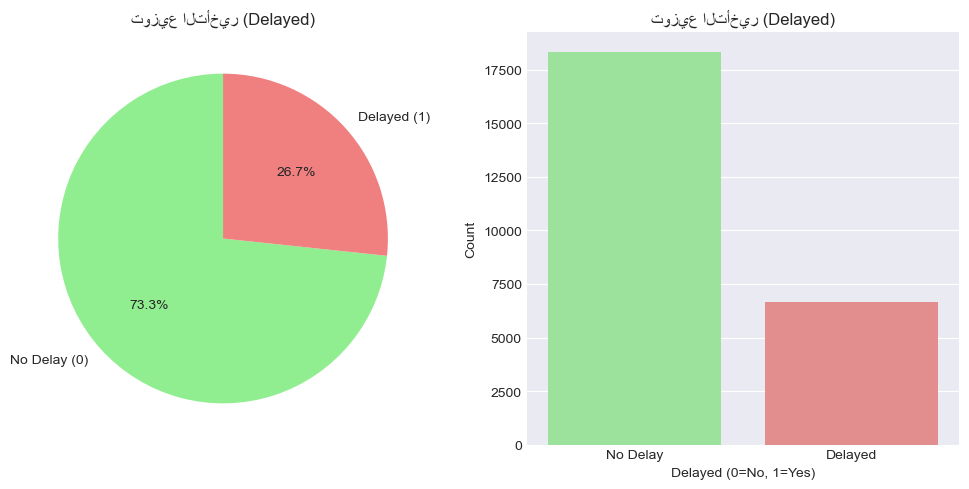


📊 إحصائيات الـ Classification:
• عدد التسليمات بدون تأخير (0): 18331 (73.3%)
• عدد التسليمات المتأخرة (1): 6669 (26.7%)


In [4]:
print("\n" + "="*50)
print("🧮 إعداد البيانات للـ CLASSIFICATION")
print("="*50)

# نسخة للـ classification
df_class = df.copy()

# تحويل delayed إلى 0 و 1
df_class['delayed'] = df_class['delayed'].map({'yes': 1, 'no': 0})

# الهدف: delayed (0 أو 1)
y_class = df_class['delayed']

# الميزات: كل شيء ما عدا المتغيرات المستهدفة
X_class = df_class.drop(['delivery_delay_hours', 'delayed', 'delivery_status', 'delivery_id', 'actual_delivery_hours', 'expected_delivery_hours'], axis=1)

# عرض توزيع الفئات
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
class_counts = y_class.value_counts()
plt.pie(class_counts, labels=['No Delay (0)', 'Delayed (1)'], 
        autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'], startangle=90)
plt.title('توزيع التأخير (Delayed)')

plt.subplot(1, 2, 2)
sns.countplot(x=y_class, palette=['lightgreen', 'lightcoral'])
plt.title('توزيع التأخير (Delayed)')
plt.xlabel('Delayed (0=No, 1=Yes)')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Delay', 'Delayed'])

plt.tight_layout()
plt.show()

print("\n📊 إحصائيات الـ Classification:")
print(f"• عدد التسليمات بدون تأخير (0): {class_counts[0]} ({class_counts[0]/len(y_class)*100:.1f}%)")
print(f"• عدد التسليمات المتأخرة (1): {class_counts[1]} ({class_counts[1]/len(y_class)*100:.1f}%)")

In [5]:
print("\n" + "="*50)
print("🔧 تعريف أنواع الميزات")
print("="*50)

# الميزات العددية
numerical_features = ['distance_km', 'package_weight_kg', 'delivery_cost', 'delivery_rating']

# الميزات الفئوية
categorical_features = ['delivery_partner', 'package_type', 'vehicle_type', 
                        'delivery_mode', 'region', 'weather_condition']

print(f"الميزات العددية ({len(numerical_features)}): {numerical_features}")
print(f"الميزات الفئوية ({len(categorical_features)}): {categorical_features}")

# التحقق من وجود الميزات في البيانات
print("\n✅ التحقق من الميزات:")
for feature in numerical_features + categorical_features:
    if feature in X_reg.columns:
        print(f"✓ {feature}")
    else:
        print(f"✗ {feature} - غير موجود!")


🔧 تعريف أنواع الميزات
الميزات العددية (4): ['distance_km', 'package_weight_kg', 'delivery_cost', 'delivery_rating']
الميزات الفئوية (6): ['delivery_partner', 'package_type', 'vehicle_type', 'delivery_mode', 'region', 'weather_condition']

✅ التحقق من الميزات:
✓ distance_km
✓ package_weight_kg
✓ delivery_cost
✓ delivery_rating
✓ delivery_partner
✓ package_type
✓ vehicle_type
✓ delivery_mode
✓ region
✓ weather_condition



🚀 بناء نموذج REGRESSION (Linear Regression)
حجم بيانات التدريب: 22500 عينة
حجم بيانات الاختبار: 2500 عينة

🔄 تدريب نموذج الـ Regression...
✅ تم تدريب النموذج بنجاح!

📊 نتائج الـ Regression Model:
• Mean Squared Error (MSE): 3.07
• Root Mean Squared Error (RMSE): 1.75 ساعات
• R-squared (R²): 0.95

📈 تحليل الأخطاء:
• متوسط الخطأ: -0.09 ساعات
• الانحراف المعياري للأخطاء: 1.75 ساعات
• الحد الأقصى للخطأ: 6.09 ساعات
• الحد الأدنى للخطأ: -5.58 ساعات


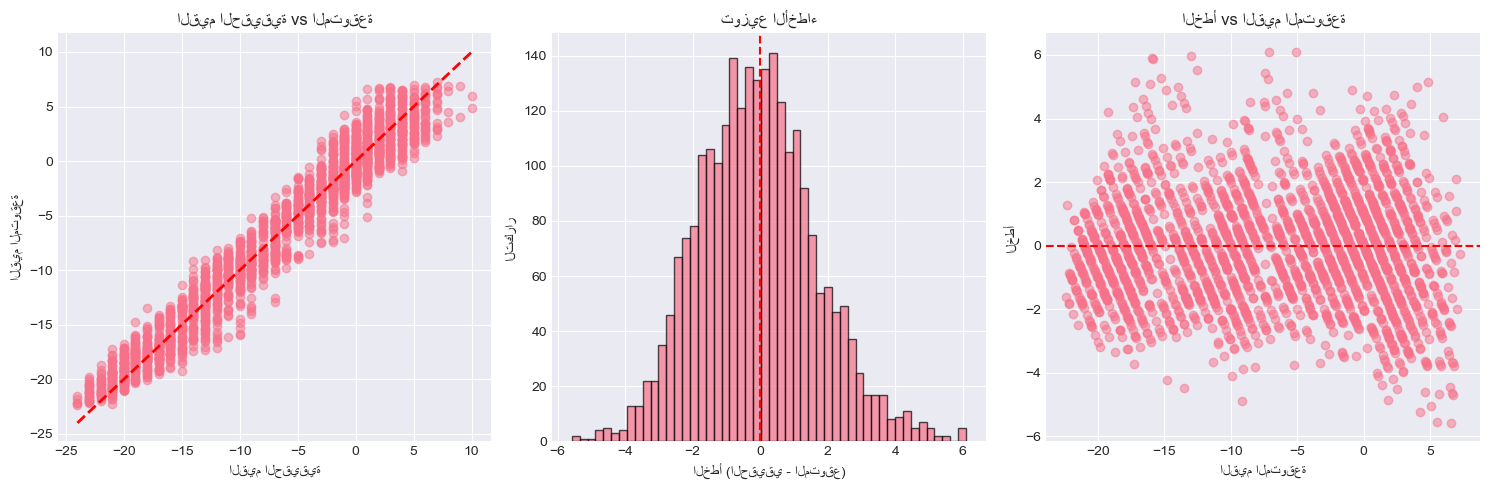


🏆 أهم 10 ميزات المؤثرة في التأخير:
                 Feature  Coefficient
  delivery_mode_standard   -10.817417
   delivery_mode_express     8.275376
  delivery_mode_same day     5.385738
             distance_km     3.806677
   delivery_mode_two day    -2.843697
weather_condition_stormy     2.457007
           delivery_cost    -2.145553
 weather_condition_rainy     1.453156
  weather_condition_cold    -1.391375
 weather_condition_clear    -1.384917


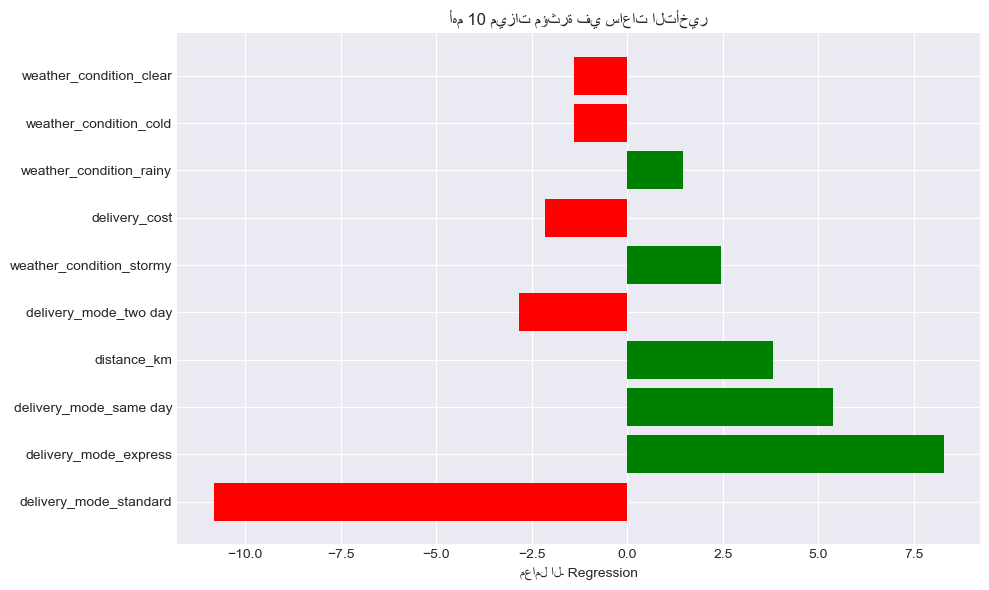

In [6]:
print("\n" + "="*50)
print("🚀 بناء نموذج REGRESSION (Linear Regression)")
print("="*50)

# تقسيم البيانات للـ regression
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.1, random_state=42, stratify=y_reg > 0  # stratification للحفاظ على التوزيع
)

print(f"حجم بيانات التدريب: {X_reg_train.shape[0]} عينة")
print(f"حجم بيانات الاختبار: {X_reg_test.shape[0]} عينة")

# بناء الـ pipeline
reg_pipeline = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])),
    ('regressor', LinearRegression())
])

# تدريب النموذج
print("\n🔄 تدريب نموذج الـ Regression...")
reg_pipeline.fit(X_reg_train, y_reg_train)
print("✅ تم تدريب النموذج بنجاح!")

# التنبؤ
y_reg_pred = reg_pipeline.predict(X_reg_test)

# تقييم النموذج
mse = mean_squared_error(y_reg_test, y_reg_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_reg_test, y_reg_pred)

print("\n📊 نتائج الـ Regression Model:")
print(f"• Mean Squared Error (MSE): {mse:.2f}")
print(f"• Root Mean Squared Error (RMSE): {rmse:.2f} ساعات")
print(f"• R-squared (R²): {r2:.2f}")

# تحليل الأخطاء
errors = y_reg_test - y_reg_pred
print(f"\n📈 تحليل الأخطاء:")
print(f"• متوسط الخطأ: {errors.mean():.2f} ساعات")
print(f"• الانحراف المعياري للأخطاء: {errors.std():.2f} ساعات")
print(f"• الحد الأقصى للخطأ: {errors.max():.2f} ساعات")
print(f"• الحد الأدنى للخطأ: {errors.min():.2f} ساعات")

# تصور النتائج
plt.figure(figsize=(15, 5))

# 1. القيم الحقيقية vs المتوقعة
plt.subplot(1, 3, 1)
plt.scatter(y_reg_test, y_reg_pred, alpha=0.5)
plt.plot([y_reg_test.min(), y_reg_test.max()], 
         [y_reg_test.min(), y_reg_test.max()], 'r--', lw=2)
plt.xlabel('القيم الحقيقية')
plt.ylabel('القيم المتوقعة')
plt.title('القيم الحقيقية vs المتوقعة')

# 2. توزيع الأخطاء
plt.subplot(1, 3, 2)
plt.hist(errors, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel('الخطأ (الحقيقي - المتوقع)')
plt.ylabel('التكرار')
plt.title('توزيع الأخطاء')

# 3. الخطأ مقابل القيمة المتوقعة
plt.subplot(1, 3, 3)
plt.scatter(y_reg_pred, errors, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('القيم المتوقعة')
plt.ylabel('الخطأ')
plt.title('الخطأ vs القيم المتوقعة')

plt.tight_layout()
plt.show()

# عرض أهم الميزات
try:
    # الحصول على معاملات النموذج
    feature_names = (numerical_features + 
                     list(reg_pipeline.named_steps['preprocessor']
                          .transformers_[1][1]
                          .get_feature_names_out(categorical_features)))
    
    coefficients = reg_pipeline.named_steps['regressor'].coef_
    
    # إنشاء DataFrame للمعاملات
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    }).sort_values('Coefficient', key=abs, ascending=False)
    
    print("\n" + "="*50)
    print("🏆 أهم 10 ميزات المؤثرة في التأخير:")
    print("="*50)
    print(coef_df.head(10).to_string(index=False))
    
    # تصور أهم المعاملات
    plt.figure(figsize=(10, 6))
    top_features = coef_df.head(10)
    colors = ['red' if x < 0 else 'green' for x in top_features['Coefficient']]
    plt.barh(top_features['Feature'], top_features['Coefficient'], color=colors)
    plt.xlabel('معامل الـ Regression')
    plt.title('أهم 10 ميزات مؤثرة في ساعات التأخير')
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"\n⚠️ تعذر استخراج المعاملات: {e}")


🚀 بناء نموذج CLASSIFICATION (Logistic Regression)
حجم بيانات التدريب: 22500 عينة
حجم بيانات الاختبار: 2500 عينة

🔄 تدريب نموذج الـ Classification...
✅ تم تدريب النموذج بنجاح!

📊 نتائج الـ Classification Model:
• الدقة (Accuracy): 97.20%

• مصفوفة الالتباس (Confusion Matrix):
[[1793   40]
 [  30  637]]

• تقرير التصنيف (Classification Report):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1833
           1       0.94      0.96      0.95       667

    accuracy                           0.97      2500
   macro avg       0.96      0.97      0.96      2500
weighted avg       0.97      0.97      0.97      2500


📈 تحليل الأداء:
• True Negatives (TN): 1793 - توقع لا تأخير وكان صحيح
• False Positives (FP): 40 - توقع تأخير وكان خطأ
• False Negatives (FN): 30 - توقع لا تأخير وكان خطأ
• True Positives (TP): 637 - توقع تأخير وكان صحيح

• Precision (الدقة): 94.09%
• Recall (الاستدعاء): 95.50%
• Specificity (النوعية): 97.82%


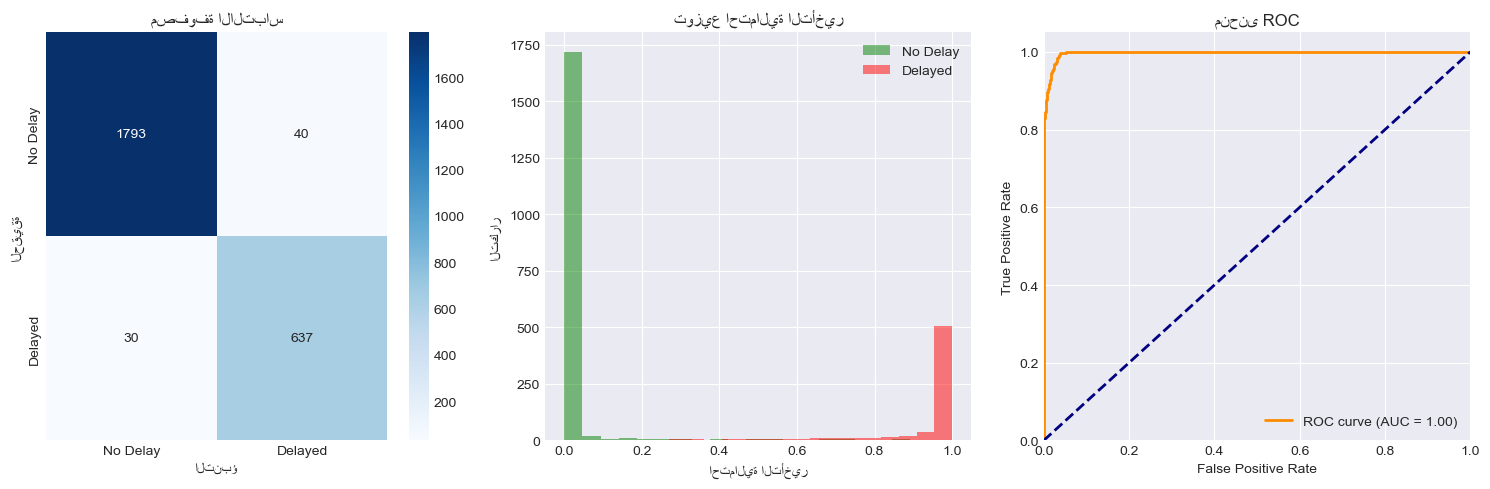


🏆 أهم 10 ميزات المؤثرة في التأخير (Classification):
                 Feature  Coefficient
         delivery_rating    -7.465641
  delivery_mode_standard    -4.689432
   delivery_mode_express     4.160998
   delivery_mode_two day    -3.736385
 weather_condition_clear    -1.918736
  weather_condition_cold    -1.814297
   weather_condition_hot    -1.628348
weather_condition_stormy     1.533715
  delivery_mode_same day     1.129987
           delivery_cost     0.991535


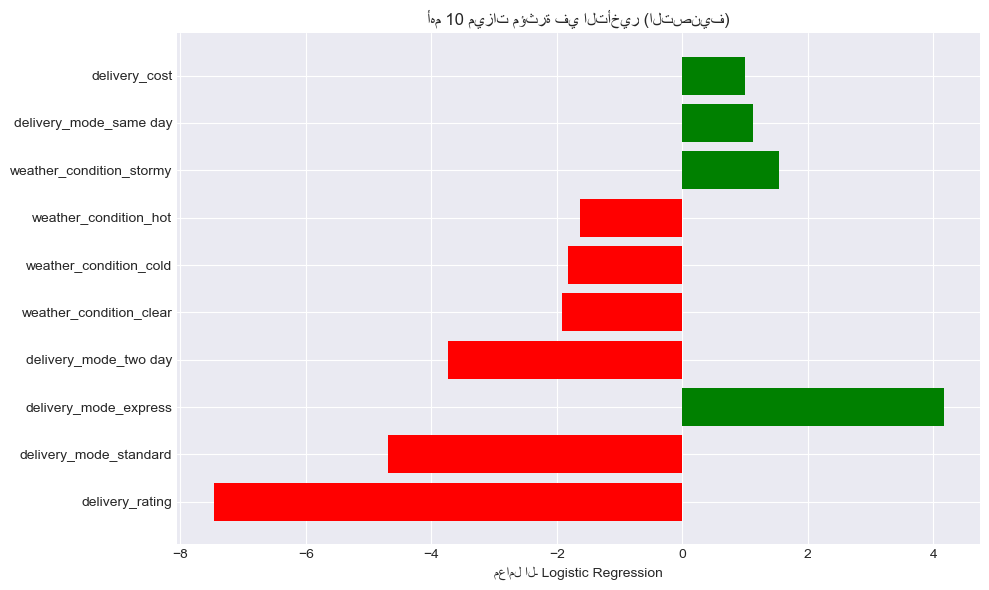

In [7]:
print("\n" + "="*50)
print("🚀 بناء نموذج CLASSIFICATION (Logistic Regression)")
print("="*50)

# تقسيم البيانات للـ classification
X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(
    X_class, y_class, test_size=0.1, random_state=42, stratify=y_class
)

print(f"حجم بيانات التدريب: {X_class_train.shape[0]} عينة")
print(f"حجم بيانات الاختبار: {X_class_test.shape[0]} عينة")

# بناء الـ pipeline
class_pipeline = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# تدريب النموذج
print("\n🔄 تدريب نموذج الـ Classification...")
class_pipeline.fit(X_class_train, y_class_train)
print("✅ تم تدريب النموذج بنجاح!")

# التنبؤ
y_class_pred = class_pipeline.predict(X_class_test)
y_class_pred_proba = class_pipeline.predict_proba(X_class_test)[:, 1]

# تقييم النموذج
accuracy = accuracy_score(y_class_test, y_class_pred)
conf_matrix = confusion_matrix(y_class_test, y_class_pred)
class_report = classification_report(y_class_test, y_class_pred)

print("\n📊 نتائج الـ Classification Model:")
print(f"• الدقة (Accuracy): {accuracy:.2%}")
print(f"\n• مصفوفة الالتباس (Confusion Matrix):")
print(conf_matrix)
print(f"\n• تقرير التصنيف (Classification Report):")
print(class_report)

# تحليل الأداء
tn, fp, fn, tp = conf_matrix.ravel()
print(f"\n📈 تحليل الأداء:")
print(f"• True Negatives (TN): {tn} - توقع لا تأخير وكان صحيح")
print(f"• False Positives (FP): {fp} - توقع تأخير وكان خطأ")
print(f"• False Negatives (FN): {fn} - توقع لا تأخير وكان خطأ")
print(f"• True Positives (TP): {tp} - توقع تأخير وكان صحيح")
print(f"\n• Precision (الدقة): {tp/(tp+fp):.2%}")
print(f"• Recall (الاستدعاء): {tp/(tp+fn):.2%}")
print(f"• Specificity (النوعية): {tn/(tn+fp):.2%}")

# تصور النتائج
plt.figure(figsize=(15, 5))

# 1. مصفوفة الالتباس
plt.subplot(1, 3, 1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Delay', 'Delayed'], 
            yticklabels=['No Delay', 'Delayed'])
plt.xlabel('التنبؤ')
plt.ylabel('الحقيقة')
plt.title('مصفوفة الالتباس')

# 2. توزيع الاحتمالات
plt.subplot(1, 3, 2)
plt.hist(y_class_pred_proba[y_class_test == 0], bins=20, alpha=0.5, 
         label='No Delay', color='green')
plt.hist(y_class_pred_proba[y_class_test == 1], bins=20, alpha=0.5, 
         label='Delayed', color='red')
plt.xlabel('احتمالية التأخير')
plt.ylabel('التكرار')
plt.title('توزيع احتمالية التأخير')
plt.legend()

# 3. منحنى ROC
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_class_test, y_class_pred_proba)
roc_auc = auc(fpr, tpr)

plt.subplot(1, 3, 3)
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('منحنى ROC')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

# عرض أهم الميزات للتصنيف
try:
    # الحصول على معاملات النموذج
    feature_names_class = (numerical_features + 
                          list(class_pipeline.named_steps['preprocessor']
                               .transformers_[1][1]
                               .get_feature_names_out(categorical_features)))
    
    coefficients_class = class_pipeline.named_steps['classifier'].coef_[0]
    
    # إنشاء DataFrame للمعاملات
    coef_class_df = pd.DataFrame({
        'Feature': feature_names_class,
        'Coefficient': coefficients_class
    }).sort_values('Coefficient', key=abs, ascending=False)
    
    print("\n" + "="*50)
    print("🏆 أهم 10 ميزات المؤثرة في التأخير (Classification):")
    print("="*50)
    print(coef_class_df.head(10).to_string(index=False))
    
    # تصور أهم المعاملات
    plt.figure(figsize=(10, 6))
    top_class_features = coef_class_df.head(10)
    colors_class = ['red' if x < 0 else 'green' for x in top_class_features['Coefficient']]
    plt.barh(top_class_features['Feature'], top_class_features['Coefficient'], color=colors_class)
    plt.xlabel('معامل الـ Logistic Regression')
    plt.title('أهم 10 ميزات مؤثرة في التأخير (التصنيف)')
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"\n⚠️ تعذر استخراج المعاملات: {e}")

In [8]:
print("\n" + "="*70)
print("📊 مقارنة بين نماذج REGRESSION و CLASSIFICATION")
print("="*70)

print("\n" + "-"*70)
print("REGRESSION MODEL (Linear Regression):")
print("-"*70)
print(f"• الهدف: توقع عدد ساعات التأخير (رقم مستمر)")
print(f"• الأداء:")
print(f"  - R²: {r2:.3f}")
print(f"  - RMSE: {rmse:.2f} ساعات")
print(f"  - متوسط الخطأ: {errors.mean():.2f} ساعات")

print("\n" + "-"*70)
print("CLASSIFICATION MODEL (Logistic Regression):")
print("-"*70)
print(f"• الهدف: توقع إذا كان هناك تأخير أم لا (0 أو 1)")
print(f"• الأداء:")
print(f"  - الدقة: {accuracy:.2%}")
print(f"  - Precision: {tp/(tp+fp):.2%}")
print(f"  - Recall: {tp/(tp+fn):.2%}")
print(f"  - AUC: {roc_auc:.3f}")

print("\n" + "-"*70)
print("📈 تحليل عملي:")
print("-"*70)
print("""
1. الـ Regression يعطيك تقدير دقيق لعدد الساعات المتأخرة/المبكرة
2. الـ Classification يعطيك إجابة مباشرة (تأخير / لا تأخير)
3. يمكن استخدام النموذجين معًا:
   - الـ Classification لتحديد إذا كان سيكون هناك تأخير
   - الـ Regression لتقدير كم ساعة سيكون التأخير
""")


📊 مقارنة بين نماذج REGRESSION و CLASSIFICATION

----------------------------------------------------------------------
REGRESSION MODEL (Linear Regression):
----------------------------------------------------------------------
• الهدف: توقع عدد ساعات التأخير (رقم مستمر)
• الأداء:
  - R²: 0.954
  - RMSE: 1.75 ساعات
  - متوسط الخطأ: -0.09 ساعات

----------------------------------------------------------------------
CLASSIFICATION MODEL (Logistic Regression):
----------------------------------------------------------------------
• الهدف: توقع إذا كان هناك تأخير أم لا (0 أو 1)
• الأداء:
  - الدقة: 97.20%
  - Precision: 94.09%
  - Recall: 95.50%
  - AUC: 0.997

----------------------------------------------------------------------
📈 تحليل عملي:
----------------------------------------------------------------------

1. الـ Regression يعطيك تقدير دقيق لعدد الساعات المتأخرة/المبكرة
2. الـ Classification يعطيك إجابة مباشرة (تأخير / لا تأخير)
3. يمكن استخدام النموذجين معًا:
   - الـ Classifica

In [9]:
print("\n" + "="*50)
print("🔮 أمثلة عملية للتنبؤ")
print("="*50)

# اختيار بعض الأمثلة من بيانات الاختبار
sample_indices = np.random.choice(range(len(X_reg_test)), 5, replace=False)

for i, idx in enumerate(sample_indices):
    print(f"\n📦 مثال {i+1}:")
    print("-"*30)
    
    # البيانات الأصلية
    actual_data = X_reg_test.iloc[idx]
    actual_delay = y_reg_test.iloc[idx]
    actual_class = y_class_test.iloc[idx] if idx < len(y_class_test) else None
    
    print(f"• المسافة: {actual_data['distance_km']:.1f} كم")
    print(f"• وزن الشحنة: {actual_data['package_weight_kg']:.1f} كجم")
    print(f"• نوع الشحنة: {actual_data['package_type']}")
    print(f"• وسيلة النقل: {actual_data['vehicle_type']}")
    print(f"• الطقس: {actual_data['weather_condition']}")
    
    # التنبؤ بالـ Regression
    reg_prediction = reg_pipeline.predict(actual_data.to_frame().T)[0]
    
    # التنبؤ بالـ Classification
    class_data = X_class_test.iloc[idx] if idx < len(X_class_test) else actual_data
    class_prediction = class_pipeline.predict(class_data.to_frame().T)[0]
    class_probability = class_pipeline.predict_proba(class_data.to_frame().T)[0][1]
    
    print(f"\n📊 النتائج:")
    print(f"• التأخير الفعلي: {actual_delay:.1f} ساعة ({'متأخر' if actual_delay > 0 else 'مبكر' if actual_delay < 0 else 'في الموعد'})")
    print(f"• التنبؤ بالـ Regression: {reg_prediction:.1f} ساعة")
    print(f"• التنبؤ بالـ Classification: {'تأخير' if class_prediction == 1 else 'لا تأخير'} ({class_probability:.1%} احتمال)")
    
    # حساب الخطأ
    if actual_class is not None:
        class_error = "صحيح" if class_prediction == actual_class else "خطأ"
        print(f"• دقة الـ Classification: {class_error}")
    
    reg_error = actual_delay - reg_prediction
    print(f"• خطأ الـ Regression: {reg_error:.1f} ساعة")


🔮 أمثلة عملية للتنبؤ

📦 مثال 1:
------------------------------
• المسافة: 134.6 كم
• وزن الشحنة: 6.9 كجم
• نوع الشحنة: groceries
• وسيلة النقل: truck
• الطقس: hot

📊 النتائج:
• التأخير الفعلي: -4.0 ساعة (مبكر)
• التنبؤ بالـ Regression: -3.2 ساعة
• التنبؤ بالـ Classification: تأخير (100.0% احتمال)
• دقة الـ Classification: صحيح
• خطأ الـ Regression: -0.8 ساعة

📦 مثال 2:
------------------------------
• المسافة: 265.0 كم
• وزن الشحنة: 2.8 كجم
• نوع الشحنة: clothing
• وسيلة النقل: van
• الطقس: clear

📊 النتائج:
• التأخير الفعلي: 2.0 ساعة (متأخر)
• التنبؤ بالـ Regression: -0.6 ساعة
• التنبؤ بالـ Classification: لا تأخير (0.0% احتمال)
• دقة الـ Classification: صحيح
• خطأ الـ Regression: 2.6 ساعة

📦 مثال 3:
------------------------------
• المسافة: 222.8 كم
• وزن الشحنة: 13.3 كجم
• نوع الشحنة: clothing
• وسيلة النقل: ev van
• الطقس: cold

📊 النتائج:
• التأخير الفعلي: -18.0 ساعة (مبكر)
• التنبؤ بالـ Regression: -17.9 ساعة
• التنبؤ بالـ Classification: تأخير (99.9% احتمال)
• دقة الـ Classific

In [10]:
# ==================================================
# 💾 الخطوة 1: حفظ النماذج باستخدام joblib
# ==================================================
import joblib

# حفظ نموذج الـ Regression
joblib.dump(reg_pipeline, 'reg_model_pipeline.joblib')
print("✅ تم حفظ نموذج الـ Regression في reg_model_pipeline.joblib")

# حفظ نموذج الـ Classification
joblib.dump(class_pipeline, 'class_model_pipeline.joblib')
print("✅ تم حفظ نموذج الـ Classification في class_model_pipeline.joblib")

✅ تم حفظ نموذج الـ Regression في reg_model_pipeline.joblib
✅ تم حفظ نموذج الـ Classification في class_model_pipeline.joblib
